## Packages and Imports

First we'll install packages as needed for Colab or our local environments and import packages.  We're using the `idlman` library from the textbook author to help with training the networks and for extracting the hidden state vectors from the trained networks.

In [1]:
# not sure about colab environment, may need to install nltk, torchtext, and ???
# !pip install torchtext
# !pip install nltk
!pip install portalocker

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IMDB
import unicodedata
import re
import string
import nltk
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
# from utils import train_model
from idlmam import set_seed, LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer

In [4]:
# configuration

# Set the theme to a dark grid with a specific palette
sns.set_theme(style="darkgrid", palette="pastel")

# Set the context for seaborn plots
sns.set_context("notebook")

torch.backends.cudnn.deterministic=True
set_seed(42)

# RNNs are SLOW on Apple Silicon, defaults to CPU for Mac
# Will choose a GPU in Colab if you're on a GPU Runtime

def get_pytorch_device(use_MPS=False):
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and use_MPS:
        return torch.device('mps')  # MPS is available on Apple Silicon Macs
    else:
        return torch.device('cpu')

device = get_pytorch_device()
print(device)

cuda


### Instantiate Datasets

Must remove `root=./data` from first line in textbook code.  If not, only half the training data gets loaded.  Also split the train set into test and validation sets.

In [5]:
train_iter, test_iter = IMDB(split=('train', 'test'))
train_dataset = list(train_iter)
test_dataset = list(test_iter)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [20000,5000], set_seed(42))

## Preprocess Text and Build Vocabulary

It's pretty common to clean text data before training a model, but the exact process may vary from model to model.
Later in this notebook we'll compare the sentiment analysis results from an LSTM trained with and without cleaned data.  In this section we'll demonstrate the clearning process.

Some common things to do with text data:
* remove stop words, these are words like 'a', 'the', etc. that don't usually change the meaning of text.
* convert unicode characters to ascii
* remove punctuation and html tags
* convert all letters to lower case

In the next few cells we'll show how this can be done.

First we'll download a commonly used list of English stopwords from NLTK:


In [6]:
# Download NLTK stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # we're going to be lazy and use this globally

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now we'll define two functions to convert unicode to ascii and to preprocess the text:

In [7]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and (c in string.ascii_letters or c == ' ')
    )

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Normalize Unicode to ASCII
    text = unicode_to_ascii(text.lower())
    # Remove all characters that are not ASCII letters, spaces or punctuation
    text = re.sub(r'[^a-z .,?!]+', ' ', text)
    # Tokenize text
    #tokens = tokenizer(text)
    tokens = text.split()
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

Here is the first review in the dataset:

In [8]:
first_review = train_dataset[0][1]
print(f'The number of characters in the first review is {len(first_review)} \n')
print(f'Here is the first review: \n\n {first_review}')

The number of characters in the first review is 1079 

Here is the first review: 

 I saW this film while at Birmingham Southern College in 1975, when it was shown in combination with the Red Balloon. Both films are similar in their dream-like quality. The bulk of the film entails a fish swimming happily in his bowl while his new owner, a little boy, is away at school. A cat enters the room where the fish and his bowl are, and begins to warily stalk his "prey." The boy begins his walk home from school, and the viewer wonders whether he will arrive in time to save his fish friend. The fish becomes agitated by the cat's presence, and finally jumps out of the bowl! The cat quickly walks over to the fish, gently picks him up with his paws, and returns him to his bowl. The boy returns happily to his fish, none the wiser.<br /><br />The ending is amazing in both its irony and its technical complexity. It is hard to imagine how the director could've pulled the technical feat back in 1959 -- i

In [9]:
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer
first_review_preproc = preprocess_text(first_review)
first_review_preproc =' '.join(first_review_preproc)
print(f'The number of characters in the first review is {len(first_review_preproc)} \n')
print(f'Here is the first preprocessed review: \n\n {first_review_preproc}')

The number of characters in the first review is 615 

Here is the first preprocessed review: 

 saw film birmingham southern college shown combination red balloon films similar dreamlike quality bulk film entails fish swimming happily bowl new owner little boy away school cat enters room fish bowl begins warily stalk prey boy begins walk home school viewer wonders whether arrive time save fish friend fish becomes agitated cats presence finally jumps bowl cat quickly walks fish gently picks paws returns bowl boy returns happily fish none wiser ending amazing irony technical complexity hard imagine director couldve pulled technical feat back seems trick find watch wont disappointed find let know get copy


## Experiment 1 - Minimally Processed Data

This is exactly what the textbook author did.  The only text processing is whatever occurs using the tokenizer and building the vocabulary.

In [10]:
from collections import Counter #how many lines in this dataset
from torchtext.vocab import vocab #we need to create a vocabulary of all the words in the training set
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']

tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer

counter = Counter()
for (label, line) in train_dataset: #loop through the training data
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" mayb

vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

In [11]:
def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handles unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x):
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]

# Sanity Check
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 12, 29, 30, 31, 24, 21, 32, 33, 21, 7, 34, 35, 36, 37, 38, 12, 39, 40, 8, 39, 41, 42, 14, 35, 43, 44, 14, 45, 46, 9, 47, 24, 35, 48, 49, 21, 50, 51, 21, 36, 52, 39, 40, 27, 14, 52, 53, 54, 0, 55, 39, 56, 24, 21, 44, 53, 39, 57, 58, 59, 47, 14, 52, 21, 60, 61, 62, 63, 64, 65, 12, 66, 54, 67, 39, 36, 68, 24, 21, 36, 69, 0, 70, 21, 48, 71, 72, 73, 14, 52, 74, 75, 76, 33, 21, 40, 77, 21, 48, 78, 79, 80, 54, 21, 36, 14, 81, 82, 83, 84, 20, 39, 0, 14, 52, 85, 83, 54, 39, 40, 24, 21, 44, 85, 38, 54, 39, 36, 14, 86, 21, 87, 24, 21, 88, 45, 89, 12, 25, 90, 91, 52, 90, 92, 93, 24, 16, 45, 94, 54, 95, 96, 21, 97, 98, 71, 99, 100, 21, 92, 101, 102, 12, 103, 104, 16, 105, 106, 35, 107, 108, 109, 24, 110, 111, 112, 113, 16, 14, 114, 16, 104, 111, 115, 71, 116, 117, 118, 77, 52, 110, 111, 0, 113, 16, 14, 119, 120, 121, 122, 4, 112, 123, 35, 124, 14, 125, 77, 2]


In [12]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)

padding_idx = vocab["<PAD>"]

embed_dim = 128
B = 64
epochs = 10

Vocab:  18076
Num Classes:  2


In [13]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch.
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch?
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

    return x, y

### Dataloaders and Training

Our network is a bidirectional LSTM with three layers.  This is straight out of the textbook, but it seems to work well.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch) # only use for final model

In [15]:
lstm1 = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D)
  nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
lstm1_results = train_network(lstm1, loss_func, train_loader, val_loader=valid_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

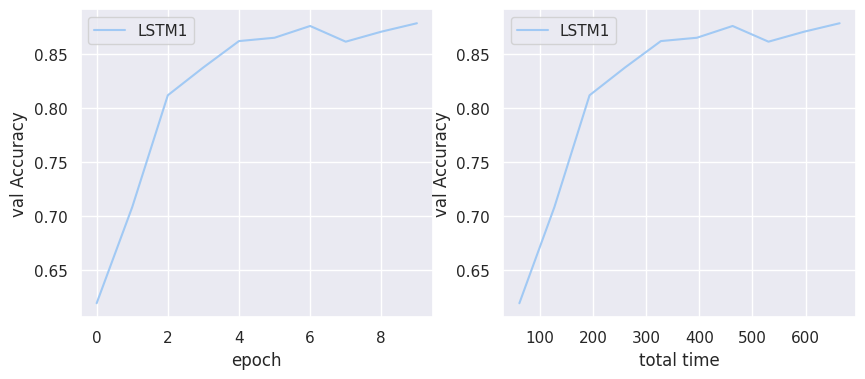

In [16]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='epoch',y='val Accuracy',data=df,label=label,ax=ax[0]);
    for label,df in label_df_dict.items():
        sns.lineplot(x='total time',y='val Accuracy',data=df,label=label,ax=ax[1]);


results_dict = {'LSTM1':lstm1_results}
make_plots(results_dict)

It looks like we're getting 86% or 87% validation accuracy without much effort.  That's pretty cool!

## Experiment 2 - Preprocessed Reviews

Here we'll preprocess the text as shown above.  The ONLY difference in the code from Experiment 1 is that we now set `tokenizer = preprocess_text` which is defined above.  There isn't much narration here because we've covered most of this above.  We also repeated much of the same code for completeness, but it's not really necessary as long as you execute the previous cells.

In [17]:
from collections import Counter #how many lines in this dataset
from torchtext.vocab import vocab #we need to create a vocabulary of all the words in the training set
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']

tokenizer = preprocess_text # set the tokenizer to be our function that adds additional processing

counter = Counter()
for (label, line) in train_dataset: #loop through the training data
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" mayb

vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

In [18]:
def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handles unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x):
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]

# Sanity Check
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 5, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 18, 21, 31, 0, 32, 33, 25, 31, 34, 35, 27, 36, 37, 38, 39, 40, 41, 18, 42, 18, 43, 0, 44, 45, 46, 47, 21, 28, 48, 49, 18, 50, 51, 0, 52, 21, 25, 52, 20, 18, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 58, 65, 66, 67, 68, 69, 70, 71, 72, 69, 73, 74, 75, 76, 2]


In [19]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)

padding_idx = vocab["<PAD>"]

embed_dim = 128
B = 64
epochs = 10

Vocab:  17811
Num Classes:  2


In [20]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch.
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch?
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

    return x, y

In [21]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=B, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [22]:
lstm2 = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D)
  nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
lstm2_results = train_network(lstm2, loss_func, train_loader, val_loader=valid_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/313 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

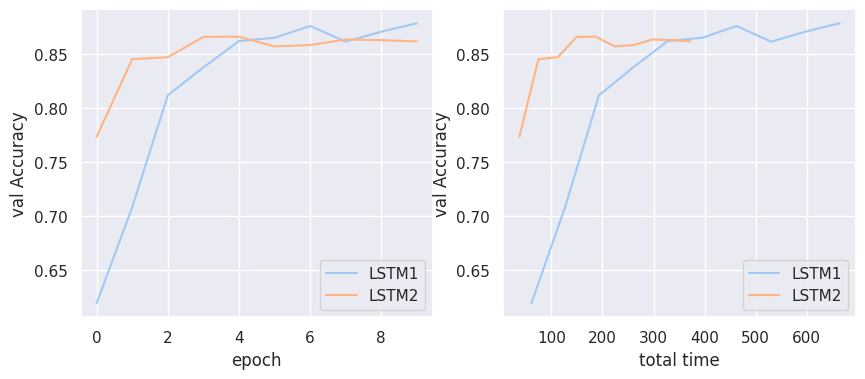

In [23]:
results_dict = {'LSTM1':lstm1_results, 'LSTM2':lstm2_results}
make_plots(results_dict)

The model is the exact same for both LSTM1 and LSTM2, but training with unprocessed data seems to attain a slightly higer validation accuracy.  We should probably train for more epochs to be certain.  However, not that the using processed reviews reduces the training time by half!  

For large models and datasets training time versus performance becomes an important consideration.